
=== Win Rate by Villager Team (all logs in folder) ===
    villager_team  games  villagers_wins  villagers_win_rate
     Interrogator     10               8               0.800
Consensus-Builder      7               5               0.714
          Analyst     10               7               0.700
          default      1               0               0.000

Saved summary to: /Users/bryanlimluoting/UndergradResearchCode/villager_team_winrates.csv
Saved raw rows to: /Users/bryanlimluoting/UndergradResearchCode/all_logs_flat.csv

=== Breakdown (villager_team × werewolf_archetype) ===
    villager_team  (unknown)_count  Chaos Agent_count  (unknown)_mean  Chaos Agent_mean
          Analyst              NaN               10.0             NaN          0.700000
Consensus-Builder              NaN                7.0             NaN          0.714286
     Interrogator              NaN               10.0             NaN          0.800000
          default              1.0                NaN     

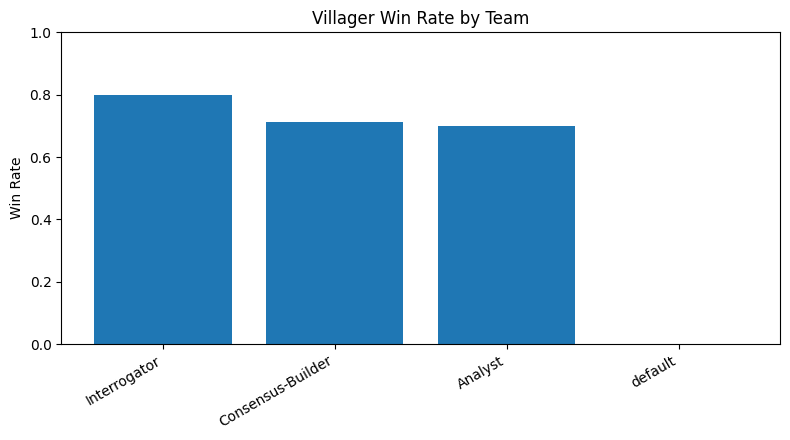

In [15]:
# ONE-CELL ANALYSIS: aggregate win rates by villager archetype for a folder of game logs
# -------------------------------------------------------------------------------------
# How to use:
# 1) Set FOLDER to the directory that contains your JSON logs
# 2) Run this cell. It will:
#    - Load all *.json logs in the folder (recursively)
#    - Parse villager team and outcome
#    - Compute villager win rate per team (and counts)
#    - Print a summary table
#    - Save a CSV next to the notebook
#    - Show a quick bar chart
#
# Assumptions:
# - Filenames may look like: game_5agents_2rounds_Chaos Agent__vg_Analyst_run1.json
# - Or anything else; villager team and wolf archetype are also read from JSON metadata if present.

import os, re, json, glob, math, textwrap
from collections import defaultdict, Counter
import pandas as pd
import matplotlib.pyplot as plt

# ====== EDIT ME ======
FOLDER = "batch4.1_chaosAgent_homogeneous_villagerTeam"  # path to your logs folder
# =====================

def find_jsons(folder: str):
    # search folder and subfolders for .json files
    pattern = os.path.join(folder, "**", "*.json")
    return sorted(glob.glob(pattern, recursive=True))

def parse_from_filename(fname: str):
    """
    Attempt to extract (wolf_arch, villager_team) from filename like:
      game_5agents_2rounds_Chaos Agent__vg_Analyst_run1.json
    Falls back to (None, None) if not matched.
    """
    base = os.path.basename(fname)
    # Split on "__vg_" if present
    m = re.match(r"^game_\d+agents_\d+rounds_(.+)__vg_(.+)_run\d+\.json$", base)
    if m:
        wolf_arch = m.group(1)
        vg_team = m.group(2).replace("_", " ")
        return wolf_arch, vg_team
    return None, None

def load_log(path: str):
    try:
        with open(path, "r") as f:
            return json.load(f)
    except Exception as e:
        print(f"[warn] Failed to read {path}: {e}")
        return None

def get_meta_fields(obj: dict, fallback_wolf: str|None, fallback_vg: str|None):
    meta = obj.get("metadata", {})
    wolf = meta.get("werewolf_archetype") or fallback_wolf
    vg_team = meta.get("villager_team") or fallback_vg
    winner = obj.get("winner")
    return wolf, vg_team, winner

def summarize(folder: str):
    files = find_jsons(folder)
    if not files:
        print(f"[info] No JSON logs found under: {os.path.abspath(folder)}")
        return None, None

    rows = []
    for path in files:
        fallback_wolf, fallback_vg = parse_from_filename(path)
        obj = load_log(path)
        if not obj:
            continue
        wolf, vg_team, winner = get_meta_fields(obj, fallback_wolf, fallback_vg)

        # Some safety checks: if vg_team missing, try to infer from archetypes (if homogeneous)
        if not vg_team:
            archs = (obj.get("metadata") or {}).get("archetypes") or {}
            villager_arches = [a for aid,a in archs.items() if (obj["metadata"]["roles"].get(aid) == "villager")]
            if villager_arches:
                # If all villagers share the same archetype, infer it
                if len(set(villager_arches)) == 1:
                    vg_team = villager_arches[0]

        rows.append({
            "file": os.path.relpath(path, folder),
            "werewolf_archetype": wolf,
            "villager_team": vg_team,
            "winner": winner
        })

    df = pd.DataFrame(rows)
    if df.empty:
        print(f"[info] No valid rows parsed from: {os.path.abspath(folder)}")
        return None, None

    # Cleanups
    df["villager_team"] = df["villager_team"].fillna("(unknown)")
    df["werewolf_archetype"] = df["werewolf_archetype"].fillna("(unknown)")
    df["villagers_win"] = (df["winner"].str.lower() == "villagers")

    # Group by villager team (across all wolf archetypes found in the folder)
    grp = df.groupby("villager_team").agg(
        games=("file", "count"),
        villagers_wins=("villagers_win", "sum")
    ).reset_index()
    grp["villagers_win_rate"] = (grp["villagers_wins"] / grp["games"]).round(3)

    # Also compute a two-way pivot for diagnostics (villager team x wolf archetype)
    pivot = (
        df.pivot_table(index="villager_team", columns="werewolf_archetype",
                       values="villagers_win", aggfunc=["count", "mean"])
        .sort_index()
    )
    # Flatten pivot columns
    pivot.columns = [f"{lvl2}_{lvl1}" for lvl1, lvl2 in pivot.columns]
    pivot = pivot.reset_index()

    return df, grp, pivot

df_logs, summary_by_team, pivot = summarize(FOLDER)

if df_logs is None:
    # quit early if no data
    pass
else:
    print("\n=== Win Rate by Villager Team (all logs in folder) ===")
    print(summary_by_team.sort_values(["villagers_win_rate","games","villager_team"], ascending=[False, False, True]).to_string(index=False))

    # Save CSVs
    out_csv_summary = os.path.join(".", "villager_team_winrates.csv")
    out_csv_raw = os.path.join(".", "all_logs_flat.csv")
    summary_by_team.to_csv(out_csv_summary, index=False)
    df_logs.to_csv(out_csv_raw, index=False)
    print(f"\nSaved summary to: {os.path.abspath(out_csv_summary)}")
    print(f"Saved raw rows to: {os.path.abspath(out_csv_raw)}")

    # Optional: show breakdown by (villager_team x werewolf_archetype)
    if pivot is not None and not pivot.empty:
        print("\n=== Breakdown (villager_team × werewolf_archetype) ===")
        # Only print columns that exist; display means (win rates) and counts side by side if present
        print(pivot.to_string(index=False))

    # Quick bar chart
    plt.figure(figsize=(8, 4.5))
    order = summary_by_team.sort_values("villagers_win_rate", ascending=False)
    plt.bar(order["villager_team"], order["villagers_win_rate"])
    plt.title("Villager Win Rate by Team")
    plt.ylabel("Win Rate")
    plt.ylim(0, 1)
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()



=== batch4.2_default_homogeneous_villagerTeam — Win Rate by Villager Team ===


,villager_team,games,villagers_wins,villagers_win_rate
0,Analyst,10,4,0.400
1,Consensus-Builder,3,1,0.333
2,Interrogator,10,2,0.200
3,default,1,0,0.000


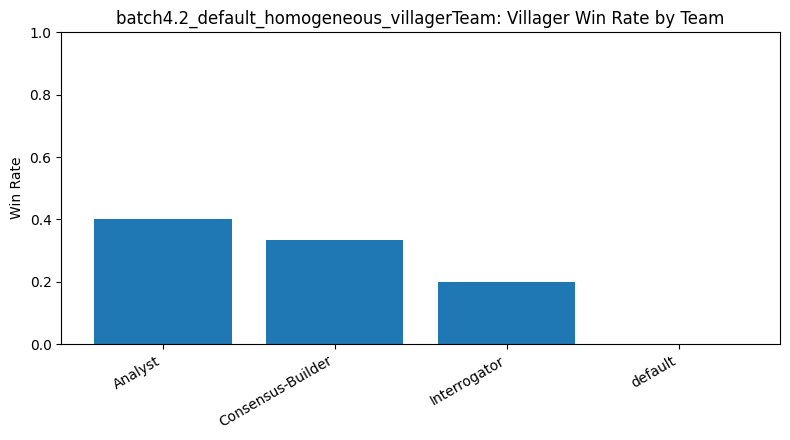

In [16]:
# CELL: batch4.2_default_homogeneous_villagerTeam
FOLDER = "batch4.2_default_homogeneous_villagerTeam"

df_logs, summary_by_team, pivot = summarize(FOLDER)
assert df_logs is not None, f"No JSON logs found in {FOLDER}"

print(f"\n=== {FOLDER} — Win Rate by Villager Team ===")
display(summary_by_team.sort_values(["villagers_win_rate","games","villager_team"],
                                    ascending=[False, False, True]))

# Bar chart
plt.figure(figsize=(8, 4.5))
order = summary_by_team.sort_values("villagers_win_rate", ascending=False)
plt.bar(order["villager_team"], order["villagers_win_rate"])
plt.title(f"{FOLDER}: Villager Win Rate by Team")
plt.ylabel("Win Rate")
plt.ylim(0, 1)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()



=== batch4.3_silentHunter_homogeneous_villagerTeam — Win Rate by Villager Team ===


,villager_team,games,villagers_wins,villagers_win_rate
1,Consensus-Builder,3,2,0.667
0,Analyst,10,5,0.500
2,Interrogator,10,4,0.400
3,default,1,0,0.000


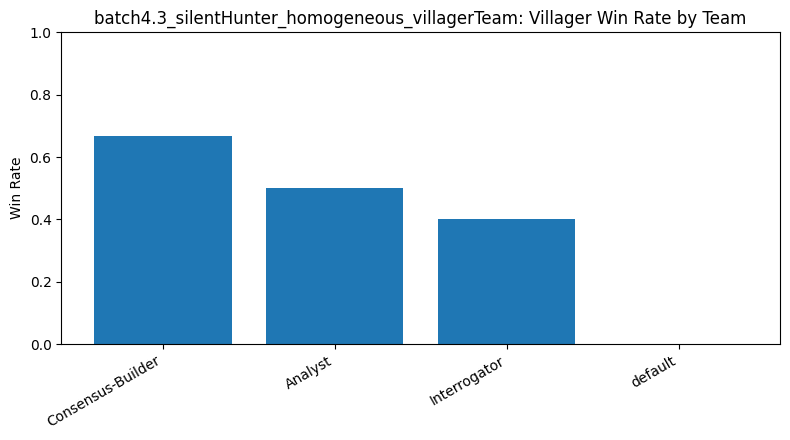

In [17]:
# CELL: batch4.2_default_homogeneous_villagerTeam
FOLDER = "batch4.3_silentHunter_homogeneous_villagerTeam"

df_logs, summary_by_team, pivot = summarize(FOLDER)
assert df_logs is not None, f"No JSON logs found in {FOLDER}"

print(f"\n=== {FOLDER} — Win Rate by Villager Team ===")
display(summary_by_team.sort_values(["villagers_win_rate","games","villager_team"],
                                    ascending=[False, False, True]))

# Bar chart
plt.figure(figsize=(8, 4.5))
order = summary_by_team.sort_values("villagers_win_rate", ascending=False)
plt.bar(order["villager_team"], order["villagers_win_rate"])
plt.title(f"{FOLDER}: Villager Win Rate by Team")
plt.ylabel("Win Rate")
plt.ylim(0, 1)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()



=== batch4.4_Manipulator_homogeneous_villagerTeam — Win Rate by Villager Team ===


,villager_team,games,villagers_wins,villagers_win_rate
0,Analyst,10,8,0.8
2,Interrogator,10,4,0.4
1,Consensus-Builder,1,0,0.0
3,default,1,0,0.0


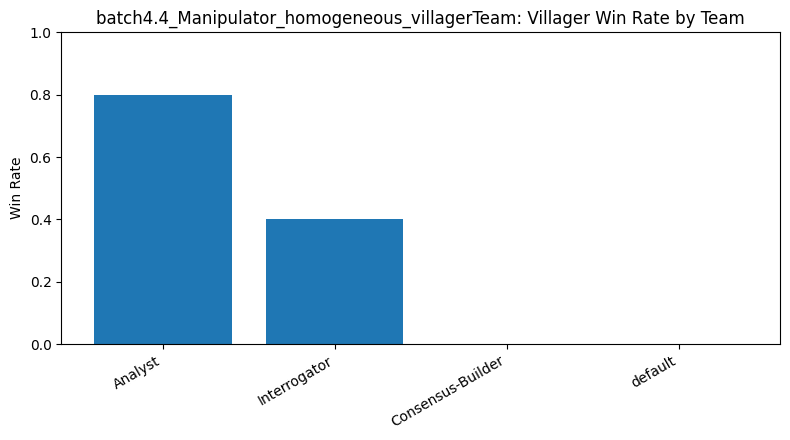

In [18]:
# CELL: batch4.2_default_homogeneous_villagerTeam
FOLDER = "batch4.4_Manipulator_homogeneous_villagerTeam"

df_logs, summary_by_team, pivot = summarize(FOLDER)
assert df_logs is not None, f"No JSON logs found in {FOLDER}"

print(f"\n=== {FOLDER} — Win Rate by Villager Team ===")
display(summary_by_team.sort_values(["villagers_win_rate","games","villager_team"],
                                    ascending=[False, False, True]))

# Bar chart
plt.figure(figsize=(8, 4.5))
order = summary_by_team.sort_values("villagers_win_rate", ascending=False)
plt.bar(order["villager_team"], order["villagers_win_rate"])
plt.title(f"{FOLDER}: Villager Win Rate by Team")
plt.ylabel("Win Rate")
plt.ylim(0, 1)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()
